In [461]:
!pip install statsmodels



import pandas as pd
import numpy as np
from math import sqrt
import holidays
import pmdarima as pm
from prophet import Prophet
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from datetime import datetime
from holidays import Germany


from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#from config.paths import SAMPLE_DIR, ROOT_DIR

# Set your seed
seed = np.random.seed(42)

In [462]:

# Setting seaborn plot style
sns.set(style="whitegrid")

# Setting the default figure size
plt.rcParams['figure.figsize'] = [10, 5]  # Width, height in inches

# Setting other plot parameters
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 2
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [463]:
stations_info = pd.read_csv('data/stations.csv')
stations_data = pd.read_csv('data/sample/stations/2023-05-03-stations.csv')
# prices_data = pd.read_csv(SAMPLE_DIR / 'prices' /'2023-05-03-prices.csv')

In [464]:
# Load the dataset
price_mdata = pd.read_csv('/Users/morad/Downloads/diesel.csv')

# Pick a random station
random_station = '72f7a2d4-1b77-4556-a45e-8abfb804fb3b'

# Create a new DataFrame that contains only the rows of the randomly chosen station
price_mdata = price_mdata[price_mdata['station'] == random_station]
price_mdata = price_mdata[['date', 'diesel']]
price_mdata.reset_index(drop=True, inplace=True)


In [465]:
# Limit data to one month duration
start_date = pd.to_datetime('2020-01-30', utc=True)
end_date = pd.to_datetime('2023-06-30', utc=True)

# Ensure 'date' column is in pandas datetime format
price_mdata['date'] = pd.to_datetime(price_mdata['date'])

mask = (price_mdata['date'] >= start_date) & (price_mdata['date'] <= end_date)
price_mdata = price_mdata.loc[mask]

# Reset the index of the DataFrame
#price_mdata.reset_index(drop=True, inplace=True)

In [466]:
crude_oil = pd.read_csv('/Users/morad/Desktop/fill_crude_oil_2014_2023.csv')

In [467]:
crude_oil.head()

,date,crude_oil_price
0,2014-01-02,107.940
1,2014-01-03,106.570
2,2014-01-04,106.640
3,2014-01-05,106.675
4,2014-01-06,106.710


In [468]:
# Convert both date columns to datetime

price_mdata['date'] = pd.to_datetime(price_mdata['date'], utc=True)
#price_mdata['date'] = price_mdata['date'].dt.date


In [469]:
price_mdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29302 entries, 49274 to 78575
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    29302 non-null  datetime64[ns, UTC]
 1   diesel  29302 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 686.8 KB


In [470]:
crude_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3444 entries, 0 to 3443
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             3444 non-null   object 
 1   crude_oil_price  3444 non-null   float64
dtypes: float64(1), object(1)
memory usage: 53.9+ KB


In [471]:
# Convert 'date' in crude_oil to datetime, and set the timezone to UTC
crude_oil['date'] = pd.to_datetime(crude_oil['date']).dt.tz_localize('UTC')

# Set 'date' as index
crude_oil.set_index('date', inplace=True)

# Resample 'crude_oil' to match the frequency of 'price_mdata' (assuming it's hourly)
crude_oil = crude_oil.resample('H').ffill()

# Reset the index
crude_oil.reset_index(inplace=True)

# Now 'date' in both dataframes are in datetime format and have the same timezone
# So, you can merge them on 'date'
merged_df = pd.merge(price_mdata, crude_oil, on='date', how='left')

# Fill missing crude_oil_price values
merged_df['crude_oil_price'] = merged_df['crude_oil_price'].fillna(method='ffill')
merged_df['crude_oil_price'] = merged_df['crude_oil_price'].fillna(method='bfill')


In [472]:
price_mdata = merged_df.copy()

In [473]:
price_mdata

,date,diesel,crude_oil_price
0,2020-01-30 00:00:00+00:00,1.269000,57.72
1,2020-01-30 01:00:00+00:00,1.269000,57.72
2,2020-01-30 02:00:00+00:00,1.269000,57.72
3,2020-01-30 03:00:00+00:00,1.269000,57.72
4,2020-01-30 04:00:00+00:00,1.306500,57.72
...,...,...,...
29297,2023-06-06 17:00:00+00:00,1.547605,74.98
29298,2023-06-06 18:00:00+00:00,1.554319,74.98
29299,2023-06-06 19:00:00+00:00,1.530111,74.98
29300,2023-06-06 20:00:00+00:00,1.519000,74.98


In [474]:
import geopy
from geopy.geocoders import Nominatim

def get_state_by_coordinates(lat, long):
    geolocator = Nominatim(user_agent="geoapiExercises")
    location = geolocator.reverse((lat, long), exactly_one=True)
    address = location.raw['address']
    state = address.get('state', "")
    return state

def get_location_state_by_uuid(uuid):
    station_row = stations_data[stations_data['uuid'] == uuid]
    if not station_row.empty:
        latitude = station_row['latitude'].values[0]
        longitude = station_row['longitude'].values[0]
        state = get_state_by_coordinates(latitude, longitude)
        return state
    else:
        return "No station with this UUID found"

# Example usage
uuid = random_station  # Replace with the desired UUID
state = get_location_state_by_uuid(uuid)
print("State:", state)


State: Nordrhein-Westfalen


In [475]:
# german_state_abbreviations = [
#     'BW',  # Baden-Württemberg
#     'BY',  # Bayern
#     'BE',  # Berlin
#     'BB',  # Brandenburg
#     'HB',  # Bremen
#     'HH',  # Hamburg
#     'HE',  # Hessen
#     'MV',  # Mecklenburg-Vorpommern
#     'NI',  # Niedersachsen
#     'NW',  # Nordrhein-Westfalen
#     'RP',  # Rheinland-Pfalz
#     'SL',  # Saarland
#     'SN',  # Sachsen
#     'ST',  # Sachsen-Anhalt
#     'SH',  # Schleswig-Holstein
#     'TH'   # Thüringen
# ]

In [476]:
holidays = holidays.Germany(state='NW') 
state = 'NW'

In [477]:
from datetime import datetime
import holidays

# def get_german_holidays(data, state):
#     # Convert the 'date' column to datetime
#     data['date'] = data['date'].dt.tz_convert('UTC')
#     #data['date'] = pd.to_datetime(data['date']).dt.tz_localize('UTC')

#     # Get the minimum and maximum date (start date and end date)
#     start_date_h = data['date'].min()
#     end_date_h = data['date'].max()

#     # Retrieve German holidays within the specified date range
#     german_holidays = holidays.Germany(years=range(start_date_h.year, end_date_h.year + 1), prov=state)

#     # Create a new 'IsHoliday' column in the DataFrame
#     data['IsHoliday'] = 0

#     # Set 'IsHoliday' to 1 if the date is a holiday
#     data.loc[data['date'].dt.normalize().isin(german_holidays.keys()), 'IsHoliday'] = 1

#     return data

# # Example usage
# price_mdata = get_german_holidays(price_mdata, state='NW')

In [478]:
price_mdata

,date,diesel,crude_oil_price
0,2020-01-30 00:00:00+00:00,1.269000,57.72
1,2020-01-30 01:00:00+00:00,1.269000,57.72
2,2020-01-30 02:00:00+00:00,1.269000,57.72
3,2020-01-30 03:00:00+00:00,1.269000,57.72
4,2020-01-30 04:00:00+00:00,1.306500,57.72
...,...,...,...
29297,2023-06-06 17:00:00+00:00,1.547605,74.98
29298,2023-06-06 18:00:00+00:00,1.554319,74.98
29299,2023-06-06 19:00:00+00:00,1.530111,74.98
29300,2023-06-06 20:00:00+00:00,1.519000,74.98


In [479]:
def get_german_holidays(data, state):
    # Convert the 'date' column to datetime if it is not already
    if not pd.core.dtypes.common.is_datetime64_any_dtype(data['date']):
        data['date'] = pd.to_datetime(data['date'])
        
    # Create a separate column for the date part only
    data['date_only'] = data['date'].dt.date

    # Get the minimum and maximum date (start date and end date)
    start_date_h = data['date'].min().date()
    end_date_h = data['date'].max().date()

    # Retrieve German holidays within the specified date range
    german_holidays = holidays.Germany(years=range(start_date_h.year, end_date_h.year + 1), prov=state)

    # Create a new 'IsHoliday' column in the DataFrame
    data['IsHoliday'] = 0

    # Set 'IsHoliday' to 1 if the date part is a holiday
    data.loc[data['date_only'].isin(german_holidays.keys()), 'IsHoliday'] = 1
    
    # Drop the 'date_only' column as we don't need it anymore
    data = data.drop(columns='date_only')

    return data

# Example usage
price_mdata = get_german_holidays(price_mdata, state='NW')


In [480]:
price_mdata['IsHoliday'].value_counts()


0    28390
1      912
Name: IsHoliday, dtype: int64

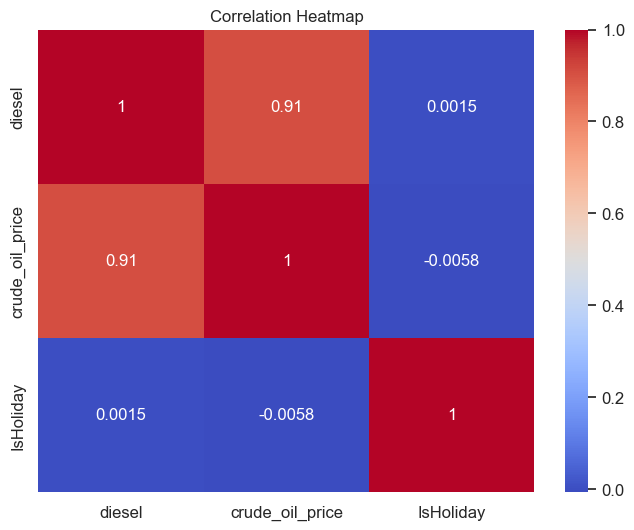

In [481]:

# Calculate the correlation matrix
corr = price_mdata[['diesel', 'crude_oil_price', 'IsHoliday']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [482]:

model = sm.tsa.statespace.SARIMAX(
    endog=price_mdata["diesel"],
    exog=price_mdata[['IsHoliday', 'crude_oil_price']],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 0, 12), # it should be 1, 1, 0, 24 but the kernel was crashed 
    enforce_invertibility=False,
    enforce_stationarity=False
).fit()
print(model.summary().tables[1])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.16436D+00    |proj g|=  1.80566D+01

At iterate    5    f= -2.44059D+00    |proj g|=  2.65954D+00

At iterate   10    f= -2.48771D+00    |proj g|=  1.14851D+00

At iterate   15    f= -2.48937D+00    |proj g|=  7.04565D-01

At iterate   20    f= -2.49006D+00    |proj g|=  2.84144D-02

At iterate   25    f= -2.49009D+00    |proj g|=  1.55319D-02

At iterate   30    f= -2.49009D+00    |proj g|=  1.13189D-02

At iterate   35    f= -2.49011D+00    |proj g|=  1.34710D-01

At iterate   40    f= -2.49036D+00    |proj g|=  2.33416D-01

At iterate   45    f= -2.49040D+00    |proj g|=  2.47485D-02


/Users/morad/.pyenv/versions/3.10.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -2.49499D+00    |proj g|=  1.36167D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     77      1     0     0   1.362D+00  -2.495D+00
  F =  -2.4949873887023579     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
IsHoliday          -0.0006      0.008     -0.072      0.943      -0.016       0.015
crude_oil_price     0.0006      0.001      0.908      0.364      -0.001       0.002
ar.L1              -0.970

In [497]:
# Copy the diesel data and set date as index
diesel_price_prediction = price_mdata[["diesel"]].copy()
diesel_price_prediction["date"] = pd.to_datetime(price_mdata["date"])
diesel_price_prediction.set_index("date", inplace=True)

# Number of additional periods to predict
additional_periods = 10

# Create a date range for prediction, now with additional_periods
prediction_index = pd.date_range(start=diesel_price_prediction.index[0], periods=len(diesel_price_prediction) + additional_periods, freq="H")

# Perform the prediction
predictions = model.predict(start=0, end=len(diesel_price_prediction)-1 + additional_periods, exog=price_mdata[['IsHoliday', 'crude_oil_price']])

# Create a new DataFrame for predictions
prediction_df = pd.DataFrame({"date": prediction_index, "Forecasting": predictions})

# Save the predictions to a CSV file
prediction_df.to_csv('/Users/morad/jurassic-juice-juggler/data_forecast/forecast_sarimax.csv', index=False)

# Print the predictions DataFrame
print(prediction_df)

# Set "date" as the index
prediction_df.set_index("date", inplace=True)

# Update the diesel_price_prediction DataFrame with the predicted values
diesel_price_prediction["Forecasting"] = prediction_df["Forecasting"]


ValueError: Provided exogenous values are not of the appropriate shape. Required (10, 2), got (29302, 2).

In [483]:
# diesel_price_prediction = price_mdata[["diesel"]].copy()
# diesel_price_prediction["date"] = pd.to_datetime(price_mdata["date"])
# diesel_price_prediction.set_index("date", inplace=True)



# # Create a date range for prediction
# prediction_index = pd.date_range(start=diesel_price_prediction.index[0], periods=len(diesel_price_prediction), freq="H")

# # Perform the prediction
# predictions = model.predict(start=0, end=len(diesel_price_prediction)-1  )

# # Create a new DataFrame for predictions
# prediction_df = pd.DataFrame({"date": prediction_index, "Forecasting": predictions})

# prediction_df.to_csv('/Users/morad/jurassic-juice-juggler/data_forecast/forecast_sarimax.csv', index=False)

# print(prediction_df)
# prediction_df.set_index("date", inplace=True)

# # Update the diesel_price_prediction DataFrame with the predicted values
# diesel_price_prediction["Forecasting"] = prediction_df["Forecasting"]

                           date  Forecasting
0     2020-01-30 00:00:00+00:00     0.035437
1     2020-01-30 01:00:00+00:00     0.870155
2     2020-01-30 02:00:00+00:00     1.416254
3     2020-01-30 03:00:00+00:00     1.213697
4     2020-01-30 04:00:00+00:00     1.289819
...                         ...          ...
29297 2023-06-03 17:00:00+00:00     1.550421
29298 2023-06-03 18:00:00+00:00     1.555290
29299 2023-06-03 19:00:00+00:00     1.535674
29300 2023-06-03 20:00:00+00:00     1.524946
29301 2023-06-03 21:00:00+00:00     1.545772

[29302 rows x 2 columns]


In [484]:
diesel_price_prediction.info()
diesel_price_prediction.index = pd.to_datetime(diesel_price_prediction.index)
diesel_price_prediction.to_csv('/Users/morad/jurassic-juice-juggler/data_forecast/forecast_sarimax.csv', index=True)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29302 entries, 2020-01-30 00:00:00+00:00 to 2023-06-06 21:00:00+00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   diesel       29302 non-null  float64
 1   Forecasting  29230 non-null  float64
dtypes: float64(2)
memory usage: 686.8 KB


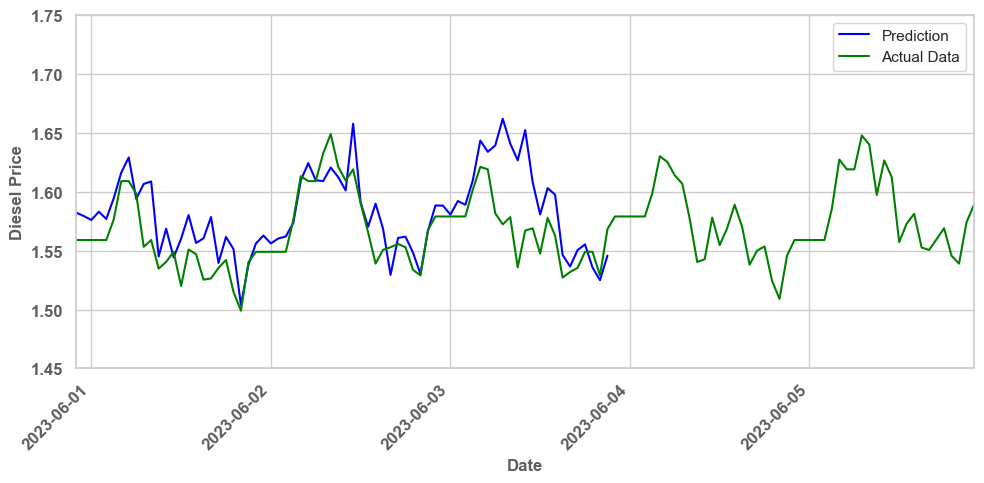

In [485]:


# # Convert lower and upper limit dates to datetime objects
lower_limit = pd.to_datetime('2023-06-01 00:00:00+02:00')
upper_limit = pd.to_datetime('2023-06-06 00:00:00+02:00')


diesel_price_prediction = diesel_price_prediction.loc[~diesel_price_prediction.index.duplicated(keep='first')]

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the DataFrame with limited y-axis range
sns.lineplot(data=diesel_price_prediction, x=diesel_price_prediction.index, y="Forecasting", ax=ax, label="Prediction", color='blue')
sns.lineplot(data=diesel_price_prediction, x=diesel_price_prediction.index, y="diesel", ax=ax, label="Actual Data", color='green')


# Customize the plot as desired
plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Diesel Price", alpha=0.75, weight="bold")
plt.xlim(pd.to_datetime('2023-06-01 00:00:00+02:00'), pd.to_datetime('2023-06-06 00:00:00+02:00'))
plt.ylim(1.45, 1.75)
ax.legend()

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [486]:
from pandas.tseries.offsets import DateOffset

# Datetimeindex dates I want to predict
future_dates = [diesel_price_prediction.index[-1] + DateOffset(hours=x) for x in range(1, 8761)]  # 8761 hours for 1 year
#future_dates = [diesel_price_prediction.index[-1] + DateOffset(day=x) for x in range(1, 365)] 

future = pd.DataFrame(index=future_dates)

diesel_price_prediction = pd.concat([diesel_price_prediction, future])


In [487]:
diesel_price_prediction

,diesel,Forecasting
2020-01-30 00:00:00+00:00,1.2690,0.035437
2020-01-30 01:00:00+00:00,1.2690,0.870155
2020-01-30 02:00:00+00:00,1.2690,1.416254
2020-01-30 03:00:00+00:00,1.2690,1.213697
2020-01-30 04:00:00+00:00,1.3065,1.289819
...,...,...
2024-06-05 17:00:00+00:00,NaN,NaN
2024-06-05 18:00:00+00:00,NaN,NaN
2024-06-05 19:00:00+00:00,NaN,NaN
2024-06-05 20:00:00+00:00,NaN,NaN


In [488]:
# Create a DataFrame for holidays with the same index as price_mdata
holidays_df = pd.DataFrame(index=price_mdata.index)

# Populate the 'IsHoliday' column based on the holiday information
holidays_df['IsHoliday'] = price_mdata['IsHoliday']

# Make sure the 'IsHoliday' column has the correct data type (bool or int)
holidays_df['IsHoliday'] = holidays_df['IsHoliday'].astype(int)  # Change to int if needed




In [489]:
start_index = 0
end_index = min(len(holidays_df) - 345, len(diesel_price_prediction) - 345)

# Initialize an empty list to store predictions
predictions = []

# Loop through each future time step
for t in range(end_index, min(end_index + 355, len(holidays_df))):
    # Get the exogenous variable for this time step
    exog = np.array(holidays_df['IsHoliday'].iloc[t]).reshape(-1, 1)
    # Predict the value for this time step
    # Predict the value for this time step
    pred = model.predict(start=t, end=t, exog=exog)
    # Extract the predicted value
    if isinstance(pred, pd.Series) or isinstance(pred, pd.DataFrame):
        pred_value = pred.iloc[0]
    else:
        pred_value = pred
    # Append the predicted value to the list
    predictions.append(pred_value)



# Create a new DataFrame for predictions
prediction_df = pd.DataFrame({"date": future_dates[:min(355, len(holidays_df) - end_index)], "Future_forcast": predictions})
prediction_df.set_index("date", inplace=True)

# Convert "Future_forcast" column in prediction_df to numeric dtype
prediction_df["Future_forcast"] = pd.to_numeric(prediction_df["Future_forcast"], errors="coerce")

# Update the diesel_price_prediction DataFrame with the predicted values
diesel_price_prediction.loc[prediction_df.index, 'Future_forcast'] = prediction_df["Future_forcast"]

# Get the confidence intervals
exog_pred = holidays_df['IsHoliday'].iloc[end_index:min(end_index + 355, len(holidays_df))].values.reshape(-1, 1)
pred = model.get_prediction(start=end_index, end=min(end_index + 354, len(holidays_df) - 1), exog=exog_pred)
pred_ci = pred.conf_int()


In [490]:
diesel_price_prediction

,diesel,Forecasting,Future_forcast
2020-01-30 00:00:00+00:00,1.2690,0.035437,NaN
2020-01-30 01:00:00+00:00,1.2690,0.870155,NaN
2020-01-30 02:00:00+00:00,1.2690,1.416254,NaN
2020-01-30 03:00:00+00:00,1.2690,1.213697,NaN
2020-01-30 04:00:00+00:00,1.3065,1.289819,NaN
...,...,...,...
2024-06-05 17:00:00+00:00,NaN,NaN,NaN
2024-06-05 18:00:00+00:00,NaN,NaN,NaN
2024-06-05 19:00:00+00:00,NaN,NaN,NaN
2024-06-05 20:00:00+00:00,NaN,NaN,NaN


In [491]:
diesel_price_prediction['Future_forcast'].value_counts()
#pred_ci.head()


1.579101    1
1.545218    1
1.636060    1
1.567039    1
1.599877    1
           ..
1.651120    1
1.650297    1
1.645970    1
1.612320    1
1.545772    1
Name: Future_forcast, Length: 345, dtype: int64

In [492]:
# import matplotlib.pyplot as plt
# import datetime

# fig, ax = plt.subplots(figsize=(12, 8))

# # Set the dark blue background
# plt.style.use('dark_background')

# plt.plot(diesel_price_prediction["diesel"], label="Actual", linewidth=2, linestyle='--', color='yellow')
# plt.plot(diesel_price_prediction["Future_forcast"], label="Prediction", linewidth=2, linestyle='-', color='red')
# #plt.plot(diesel_price_prediction["Forecasting"], label="Prediction", linewidth=3, linestyle='-', color='black')

# plt.xticks(alpha=0.75, fontsize=18, weight="bold", rotation=45, ha="right")
# plt.yticks(alpha=0.75, fontsize=18, weight="bold")

# plt.xlabel("Date", alpha=0.75, fontsize=18, weight="bold")
# plt.ylabel("Diesel Price", alpha=0.75, fontsize=18, weight="bold")
# plt.xlim(lower_limit, upper_limit)
# plt.ylim(1.4, 2.1)

# plt.legend(loc='upper right', fontsize=20)

# # Save the plot as a PNG file
# plt.savefig('prediction_ARIMAX_plot.png', dpi=300, bbox_inches='tight')

# plt.show()


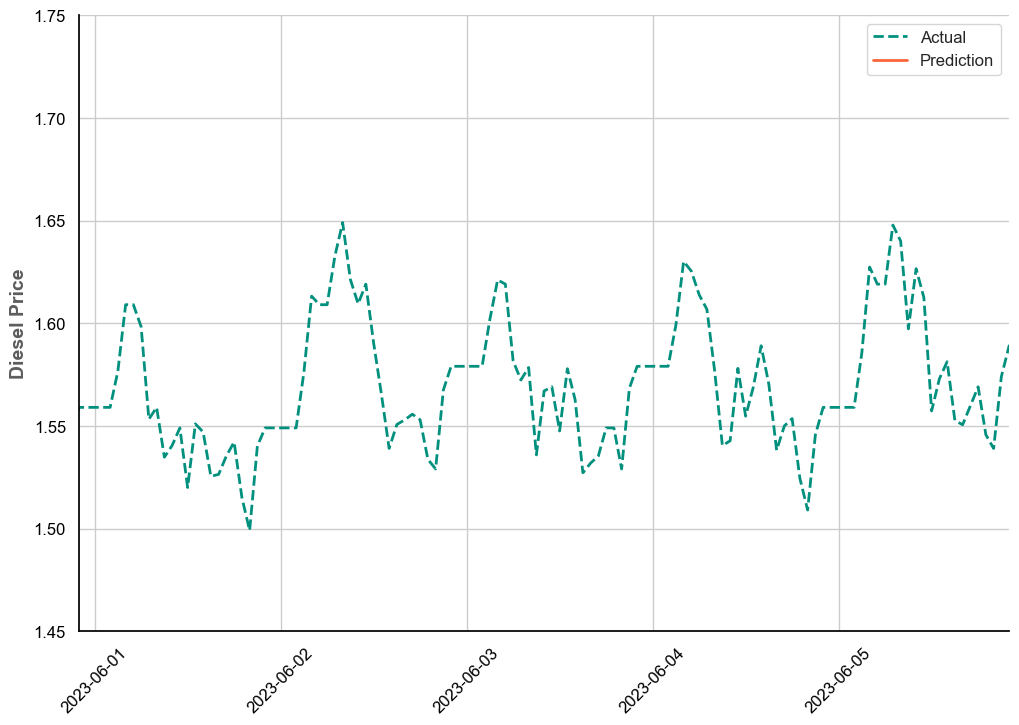

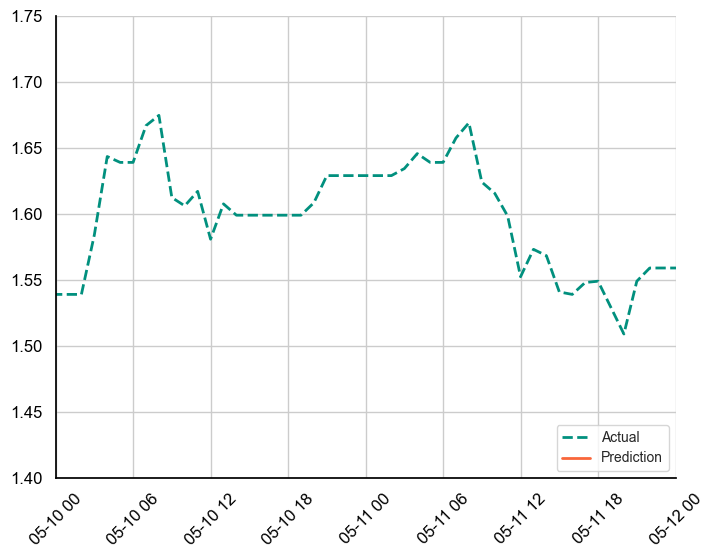

In [493]:
import matplotlib.pyplot as plt
import datetime

# plt.rcParams['axes.facecolor'] = 'white'  # Set background color to white
# plt.rcParams['axes.edgecolor'] = 'black'  # Set edge color to black

# Main colors
main_colors = ['#01907E', '#F9663A']
zoom_colors = ['#01907E', '#F9663A']

# Create the main plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(diesel_price_prediction["diesel"], label="Actual", linewidth=2, linestyle='--', color=main_colors[0])
ax.plot(diesel_price_prediction["Future_forcast"], label="Prediction", linewidth=2, linestyle='-', color=main_colors[1])
ax.set_xlim(lower_limit, upper_limit)
ax.set_ylim(1.45, 1.75)
ax.legend(loc='upper right', fontsize=12)
ax.set_ylabel("Diesel Price", alpha=0.75, fontsize=14, weight="bold")
ax.xaxis.set_tick_params(rotation=45)

# Customize the axis colors
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

# Save the main plot as a PNG file
plt.savefig('prediction_ARIMAX_plot_main.png', dpi=300, bbox_inches='tight')

# For the zoomed-in plot, let's use shades of the main colors
color_actual_zoom = 'blue'
color_prediction_zoom = 'green'

# Create the zoomed-in subplot
fig_zoom, ax_zoom = plt.subplots(figsize=(8, 6))
ax_zoom.plot(diesel_price_prediction["diesel"], label="Actual", linewidth=2, linestyle='--', color=zoom_colors[0])
ax_zoom.plot(diesel_price_prediction["Future_forcast"], label="Prediction", linewidth=2, linestyle='-', color=zoom_colors[1])
ax_zoom.set_xlim(datetime.datetime(2023, 5, 10), datetime.datetime(2023, 5, 12))
ax_zoom.set_ylim(1.4, 1.75)
ax_zoom.legend(loc='lower right', fontsize=10)
ax_zoom.xaxis.set_tick_params(rotation=45)

# Customize the axis colors for the zoomed-in plot
ax_zoom.spines['bottom'].set_color('black')
ax_zoom.spines['left'].set_color('black')
ax_zoom.spines['top'].set_visible(False)
ax_zoom.spines['right'].set_visible(False)
ax_zoom.tick_params(axis='x', colors='black')
ax_zoom.tick_params(axis='y', colors='black')

# Save the zoomed-in subplot as a PNG file
plt.savefig('prediction_ARIMAX_plot_zoom.png', dpi=300, bbox_inches='tight')

# Show both plots
plt.show()


In [494]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Replace NaN values with zeros
actual_values = np.nan_to_num(diesel_price_prediction["diesel"])
predicted_values = np.nan_to_num(diesel_price_prediction["Forecasting"])

# Calculate MSE
mse = mean_squared_error(actual_values, predicted_values)

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)



# Calculate MASE
scaling_factor = np.mean(np.abs(np.diff(actual_values)))
mase = (np.abs(actual_values - predicted_values) / scaling_factor).mean()

# Calculate R-squared score
r2 = r2_score(actual_values, predicted_values)

# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Scaled Error (MASE):", mase)
print("R2-squared score:", r2)


Mean Squared Error (MSE): 0.005834397942829904
Mean Absolute Error (MAE): 0.020612614306206166
Mean Absolute Scaled Error (MASE): 1.5355630710693993
R2-squared score: 0.9886291445485664


In [495]:


# # Calculate the differences between predicted and actual values
# diesel_price_prediction = diesel_price_prediction.dropna(subset=["Future_forcast", "diesel"])

# differences = diesel_price_prediction["Future_forcast"] - diesel_price_prediction["diesel"]

# # Add the difference column to the DataFrame
# diesel_price_prediction['difference'] = differences

# # Calculate the mean value of the difference column
# mean_difference = differences.mean()

# # Define the thresholds based on the mean difference
# threshold_high_positive = mean_difference + 0.05
# threshold_low_positive = mean_difference + 0.01
# threshold_close_to_zero = 0.01
# threshold_low_negative = mean_difference - 0.01
# threshold_high_negative = mean_difference - 0.05

# # Define the bin edges and labels
# bins = [-np.inf, threshold_high_negative, threshold_low_negative, threshold_close_to_zero, threshold_low_positive, np.inf]
# classes = [ 'Higher Negative','Lower Negative', 'Close to Zero', 'Low Positive', 'High Positive']

# # Classify the differences based on the thresholds
# diesel_price_prediction['difference'] = pd.cut(
#     differences,
#     bins=bins,
#     labels=classes,
#     duplicates='drop'
# )


# from sklearn.metrics import mean_absolute_error

# mae = mean_absolute_error(diesel_price_prediction["Future_forcast"], diesel_price_prediction["diesel"])
# print(f"Mean Absolute Error: {mae}")

# # Plot a histogram of the difference classes
# diesel_price_prediction['difference'].hist()



# # Calculate the accuracy of the predictions
# actual_classes = np.nan_to_num(diesel_price_prediction["diesel"])  # Get the actual classes corresponding to the prediction dates
# accuracy = (diesel_price_prediction['difference'] == actual_classes).mean()

# # Calculate the differences between actual values and mean of actual values
# actual_differences = diesel_price_prediction["diesel"] - diesel_price_prediction["diesel"].mean()

# # Classify the actual differences based on the thresholds
# diesel_price_prediction['actual_difference'] = pd.cut(
#     actual_differences,
#     bins=bins,
#     labels=classes,
#     duplicates='drop'
# )

# # Now you can compare 'difference' with 'actual_difference' to calculate accuracy
# accuracy = (diesel_price_prediction['difference'] == diesel_price_prediction['actual_difference']).mean()

# print(f"Accuracy: {accuracy}")

# plt.tight_layout()
# plt.savefig('diesel_price_prediction.png', dpi=300)
